# ROM 102

 - Review ROM 101 (i.e., POD-Galerkin ROMs)
 - Numerical demo using transient conduction
 - Practical considerations (nonlinearity, etc.)

# ROM 101 Review

## ROM 101 Review: The Application

Consider some dynamical system

$$
  \frac{\partial y}{\partial t} = f(y, t; \mu) 
  \tag{1}
$$

subject to appropriate initial and boundary conditions, where 
  
  - $y(\mathbf{r}, t)$ is a scalar unknown (e.g., temperature)
  - $f$ is a (possibly) nonlinear function (e.g., $\nabla k(\mathbf{r}, y) \nabla (\mathbf{r}, t) + q'''(\mathbf{r}, t)$)
  - $\mu$ represents parameters (e.g., the conductivity $k$)

## ROM 101 Review: The Full-Order Model

Application of a spatial discretization scheme to $y_t = f(y, t; \mu)$ often leads to a system of the form

$$
  \frac{d \mathbf{y}}{dt} = \mathbf{A}(t, \mathbf{y}; \boldsymbol{\mu})\mathbf{y}(t) + \mathbf{s}(t, \mathbf{y};\boldsymbol{\mu})
  \tag{2}
$$

where 

  - $\mathbf{y} \in R^n$ is the vector of unknowns at each spatial point
  - $\mathbf{s} \in R^{n}$ is a source/forcing function/load
  - $\mathbf{A} \in R^{n\times n}$ and $\mathbf{B} \in R^{n\times n}$ are matrices that may depend on time and on the unknown.

Equation (2) represents the **full-order model** (FOM).

## ROM 101 Review: The Galerkin ROM

Let

$$
  \mathbf{y}(t) \approx \sum^r_{i=1} \tilde{y}_i(t) \boldsymbol{\psi}_i = \boldsymbol{\Psi} \mathbf{\tilde{y}}(t)
  \tag{3}
$$

where 

 - $\boldsymbol{\Psi} \in R^{n\times r}$ is an orthogonal matrix ($\boldsymbol{\Psi}^T \boldsymbol{\Psi}=\mathbf{I}$) whose columns $\boldsymbol{\psi}_i$ are basis vectors
 - $\mathbf{\tilde{y}} \in R^r$ is a vector of coefficients.



**Important**: often $\boldsymbol{\Psi}$ is a "tall-skinny" matrix (more rows than columns) with $r \ll n$

## ROM 101 Review: The Galerkin ROM


Substitute $\mathbf{y} = \boldsymbol{\Psi}\mathbf{\tilde{y}}$ into $\mathbf{y}' = \mathbf{A}\mathbf{y}(t) + \mathbf{s}(t)$ and multiply the result by $\boldsymbol{\Psi}^T$ (the "projection") to get

$$
  \frac{d\mathbf{\tilde{y}}}{dt} = 
    \mathbf{\tilde{A}} \mathbf{\tilde{y}}(t) +
    \mathbf{\tilde{s}}(t) 
    \tag{4}
$$

where 

  - $\mathbf{\tilde{A}} = \boldsymbol{\Psi}^T \mathbf{\tilde{A}} \boldsymbol{\Psi} \in R^{r\times r}$
  - $\tilde{s} = \boldsymbol{\Psi}^T\mathbf{s} \in R^{r}$

**Important**: We've gone from $n$ unknowns to $r \ll n$ unknowns!

## ROM 101 Review: Snapshots and POD

Suppose we've solved the FOM for $\mathbf{y}_j$ at several times $t_j$ and defined the "snapshot" matrix $\mathbf{X} = [\mathbf{y}_0, \mathbf{y}_1, \ldots, \mathbf{y}_m] \in R^{n \times m}$, where, usually, $m < n$.

The **singular value decomposition** (SVD) of these snapshots is

$$
   \mathbf{X} = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^T = \sum_{i=1}^{m} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
   \tag{5}
$$

where $\mathbf{U} \in R^{n\times n}$ and $\mathbf{V} \in R^{m\times m}$ are orthogonal matrices, and $\boldsymbol{\Sigma} \in R^{n\times m}$ is a diagonal matrix of (nonnegative) singular values $\sigma_i$

Using just the first $r < m$ columns of $\mathbf{U}$ to define $\mathbf{X} \approx \mathbf{U}_r \boldsymbol{\Sigma}_r \mathbf{V}^T_r = \sum^r_{i=1} \sigma_i \mathbf{u}_i \mathbf{v}^T_i$ produces the best possible rank-$r$ approximation to $\mathbf{X}$ in a least-squares sense.

Now we set $\boxed{\boldsymbol{\Psi} = \mathbf{U}_r}$, and our Galerkin ROM becomes a POD-Galerkin ROM.

# Intermission: Truncated SVD and Image Compression

import matplotlib.pyplot as plt
import numpy as np
import urllib
#url = 'https://unsplash.com/photos/f1q4NlVRYSc/download?force=true&w=2400'
#urllib.request.urlretrieve(url , 'snake.jpg')
A_rgb = plt.imread('snake.jpg')   # 1737x2400 matrix of RGB tuples
plt.imshow(A_rgb);

## Compute the SVD

A = np.array(A_rgb.reshape((A_rgb.shape[0], A_rgb.shape[1]*A_rgb.shape[2])), dtype='float')
U, sigma, V = np.linalg.svd(A, compute_uv=True) # sigma is a 1-d array
plt.semilogy(sigma, 'go', mfc='w')
plt.semilogy(10, sigma[10], 'rs', 50, sigma[50], 'b^', 100, sigma[100], 'kh', mfc='None', ms=15)
plt.xlabel('$i$'); plt.ylabel('$\sigma_i$'); plt.title("Most information in first ~100 singular values.");

## Reconstruct with Truncated SVD

A_r = []
for r in [10, 50, 100]:
    Sigma = np.diag(sigma) # make Sigma a diagonal matrix
    A_r.append(U[:, :r]@(Sigma[:r, :r]@V[:r, :])) 
    A_r[-1] = np.array(A_r[-1].reshape((1737, 2400, 3)), dtype='i')
    A_r[-1][A_r[-1]<0]=0; A_r[-1][A_r[-1]>255]=255;
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axes[0, 0].imshow(A_rgb); axes[0,0].set_title('original'); tmpl = 'n={},  {:.1f}% compression'
comp = lambda n: (1-(U.shape[0]+V.shape[0])*n/A.shape[0]/A.shape[1])*100
axes[0, 1].imshow(A_r[0]); axes[0,1].set_title(tmpl.format(10, comp(10)))
axes[1, 0].imshow(A_r[1]); axes[1,0].set_title(tmpl.format(50, comp(50)))
axes[1, 1].imshow(A_r[2]); axes[1,1].set_title(tmpl.format(100, comp(100)));

# ROM 102 - Putting It All to Practice

## The Application

**Goal**: Apply POD-Galerkin to the familiar problem of transient heat conduction in plane walls, i.e.,

$$
  \rho(x)c_p(x, y) \frac{\partial y}{\partial t} 
    = \frac{\partial}{\partial x} \left ( k(x, y) \frac{\partial}{\partial x}  y(x, t)\right ) + q'''(x, t) \, ,
    \tag{6}
$$

starting with the simplest case: a homogeneous medium with constant parameters.

## The Full-Order Model

Using finite differences, we can approximate Eq. (6) as

$$
\begin{split}
 \frac{\partial y_i}{\partial t} 
  = & \left ( \frac{k_{i+1}(y_{i+1}(t)) - k_{i-1}(y_{i-1}(t))}{2\Delta_x  \rho_i c_{p,i}(y_i(t))}  \right ) 
              \left ( \frac{y_{i+1}(t) - y_{i-1}(t)}{2\Delta_x} \right ) \\
     &+ k_{i}(y_{i}(t)) \left ( \frac{y_{i+1}(t) - 2y_{i}(t) +y_{i-1}(t)}{\Delta_x^2  \rho_i c_{p,i}(y_i(t))} \right ) 
      + \frac{1}{\rho_i c_{p,i}(y_i(t))} q_i'''\, .
\end{split}
\tag{7}
$$

where, e.g., $y_i(t) = y(x_i, t)$.  

This leads to

$$
  \frac{d}{dt} 
  \begin{bmatrix}
   y_0 \\
   y_1 \\
   y_2 \\
   y_3 \\
   \vdots \\
   y_n
  \end{bmatrix}
  = 
  \begin{bmatrix}
    -1        & 1         &  0        & 0         & \ldots \\
    b_1 - a_1 & -2b_1     & b_1 + a_1 & 0         & \\
    0         & b_2 - a_2 & -2b_2     & b_2 + a_2 & \\
              &           & \ddots    &           & \\
              &           &           &           &  1
  \end{bmatrix}
  \begin{bmatrix}
   y_0 \\
   y_1 \\
   y_2 \\
   y_3 \\
   \vdots \\
   y_n
  \end{bmatrix}
  +
   \begin{bmatrix}
   0 \\
   s_1 \\
   s_2 \\
   s_3 \\
   \vdots \\
   0
  \end{bmatrix}
$$


where 

$$ 
  a_i = \frac{k_{i+1}(y_{i+1}(t)) - k_{i-1}(y_{i-1}(t))}{2\Delta_x  \rho_i c_{p,i}(y_i(t))} \, ,
$$
$$
  b_i = \frac{k_{i}}{\Delta_x^2  \rho_i c_{p,i}(y_i(t))} \, ,
  \qquad \text{and} \qquad   s_i = \frac{1}{\rho_i c_{p,i}(y_i(t))} q_i''' \, .
$$

## The Full-Order Model: Example

For a concrete example, assume that

$$
y'(0, t) = 0 \, , \quad y(1, t) = 0 \, , \quad \text{and} \quad 
 y(x, 0) = 
\begin{cases}
  1 & 0 \leq x \leq 1/2 \\
  0 & 1/2 < x \leq 1 \, .
\end{cases}
$$

and $k = 1$, $\rho = 1$, $c_p = 1$, and $q''' = 1$.  We'll solve for $t \in [0, 1]$.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from transient_conduction import *
w = 1.0  # wall width
nx = 101 # number of spatial points
t = np.linspace(0, 100, 11)
def ic(x):
    v = x**0; v[x>0.5]=0.0
    return v;
k   = lambda x, T: 1.0*x**0 
c_p = lambda x, T: 1*x**0
rho = lambda x: 1*x**0
q   = lambda x, t: 1*x**0

In [21]:
sol, x = solve(k, c_p, rho, q, ic, w=1, nx=nx, times=t)

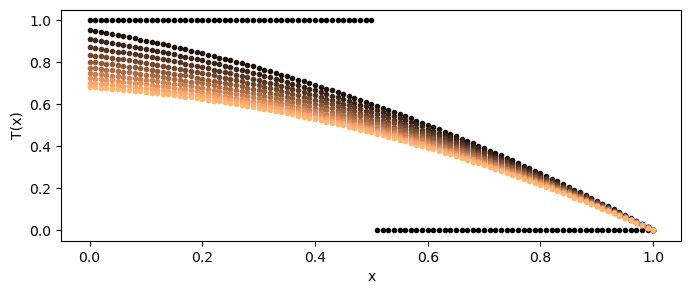

In [22]:
plt.figure(figsize=(8,3))
for i in range(len(t)):
    plt.plot(x, sol[:, i], '.', color=plt.cm.copper(i/len(t))); 
plt.xlabel("x"); plt.ylabel("T(x)");

In [23]:
sol[:, 2]

array([0.91002066, 0.90588405, 0.90164703, 0.8973096 , 0.89287177,
       0.88833354, 0.88369492, 0.87895591, 0.87411652, 0.86917675,
       0.8641366 , 0.85899607, 0.85375518, 0.84841393, 0.84297231,
       0.83743034, 0.83178801, 0.82604534, 0.82020233, 0.81425898,
       0.80821529, 0.80207127, 0.79582692, 0.78948225, 0.78303726,
       0.77649196, 0.76984634, 0.76310042, 0.7562542 , 0.74930768,
       0.74226086, 0.73511376, 0.72786637, 0.72051869, 0.71307074,
       0.70552252, 0.69787403, 0.69012527, 0.68227625, 0.67432698,
       0.66627745, 0.65812768, 0.64987766, 0.6415274 , 0.6330769 ,
       0.62452617, 0.61587521, 0.60712403, 0.59827263, 0.58932102,
       0.58026919, 0.57111716, 0.56186492, 0.55251249, 0.54305986,
       0.53350703, 0.52385403, 0.51410084, 0.50424747, 0.49429393,
       0.48424022, 0.47408634, 0.4638323 , 0.4534781 , 0.44302375,
       0.43246926, 0.42181461, 0.41105983, 0.40020491, 0.38924985,
       0.37819467, 0.36703936, 0.35578393, 0.34442839, 0.33297